In [1]:
! pip install -q "gdown==5.2.0"

In [2]:
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [4]:
!gdown --id 1aOm_WJ53R7lk16Azz_NSNumvFV3aNO39

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1aOm_WJ53R7lk16Azz_NSNumvFV3aNO39
From (redirected): https://drive.google.com/uc?id=1aOm_WJ53R7lk16Azz_NSNumvFV3aNO39&confirm=t&uuid=58b91cae-cedb-4ce0-92be-7d238d12c77c
To: /content/lung_cancer_dataset.zip
100% 178M/178M [00:04<00:00, 38.1MB/s]


In [5]:
!unzip lung_cancer_dataset.zip

Archive:  lung_cancer_dataset.zip
   creating: lung_cancer_dataset/Bengin cases/
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (1).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (10).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (100).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (101).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (102).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (103).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (104).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (105).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (106).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (107).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (108).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (109).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (11).jpg  
  inflating: 

In [6]:
def loading_the_data(data_dir):
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df

In [7]:
data_dir = '/content/lung_cancer_dataset'
df = loading_the_data(data_dir)
df

,filepaths,labels
0,/content/lung_cancer_dataset/Bengin cases/Beng...,Bengin cases
1,/content/lung_cancer_dataset/Bengin cases/Beng...,Bengin cases
2,/content/lung_cancer_dataset/Bengin cases/Beng...,Bengin cases
3,/content/lung_cancer_dataset/Bengin cases/Beng...,Bengin cases
4,/content/lung_cancer_dataset/Bengin cases/Beng...,Bengin cases
...,...,...
1195,/content/lung_cancer_dataset/Malignant cases/M...,Malignant cases
1196,/content/lung_cancer_dataset/Malignant cases/M...,Malignant cases
1197,/content/lung_cancer_dataset/Malignant cases/M...,Malignant cases
1198,/content/lung_cancer_dataset/Malignant cases/M...,Malignant cases


# Data preprocessing

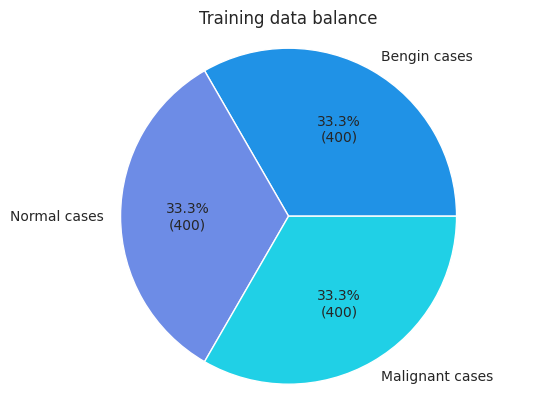

In [8]:
data_balance = df.labels.value_counts()

def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

In [9]:
# data --> 80% train data && 20% (test, val)
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

## Creating Datasets and DataLoaders

In [10]:
batch_size = 32
img_size = (224, 224)

In [11]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, class_dict=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_dict = class_dict

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filepaths']
        label = self.dataframe.iloc[idx]['labels']
        # Convert the label to an integer using the class_dict
        label = self.class_dict[label]
        # Convert label to a tensor
        label = torch.tensor(label)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [12]:
# resizing the image, converting it to a tensor, and normalizing it.
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [14]:
classes = train_df['labels'].unique()
class_dict = {label: idx for idx, label in enumerate(classes)}
reverse_class_dict = {idx: label for label, idx in class_dict.items()}

train_dataset = CustomDataset(dataframe=train_df, transform=transform, class_dict=class_dict)
valid_dataset = CustomDataset(dataframe=valid_df, transform=transform, class_dict=class_dict)
test_dataset = CustomDataset(dataframe=test_df, transform=transform, class_dict=class_dict)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Visualizing a batch of images

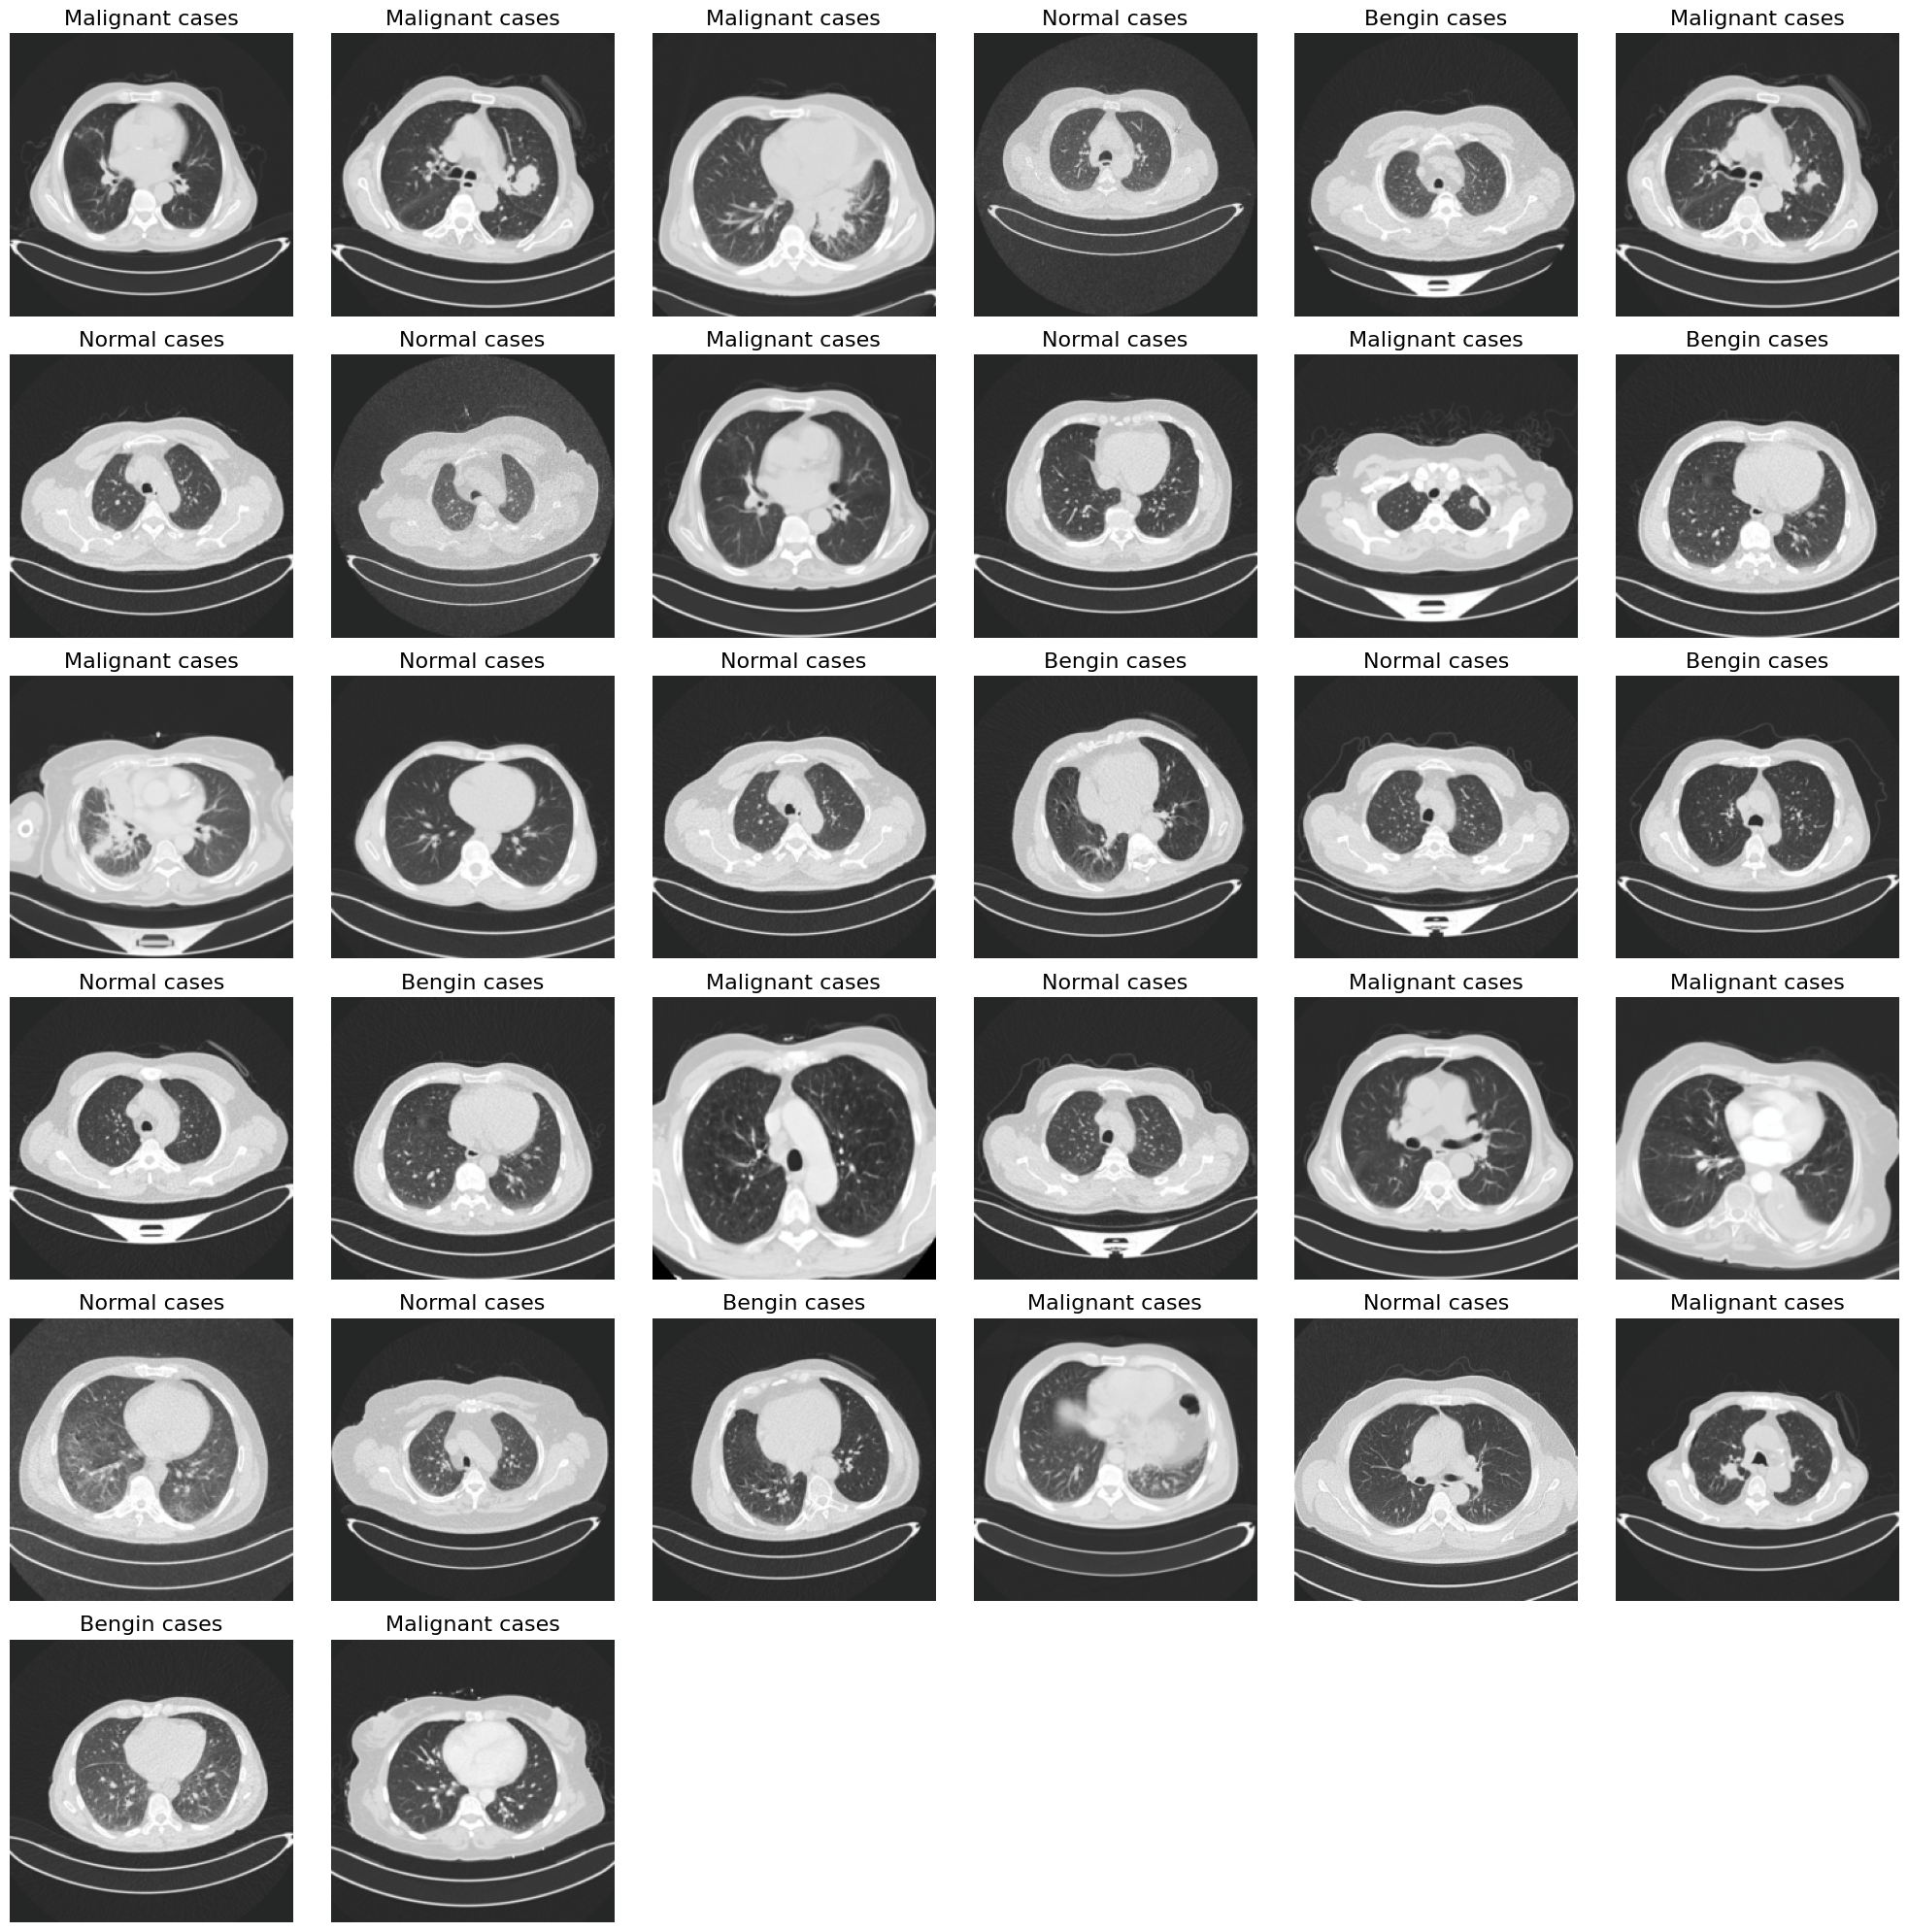

In [18]:
images, labels = next(iter(train_loader))

# Convert the images from tensor format to a format suitable for plotting
# Convert from Tensor (N, C, H, W) to NumPy (N, H, W, C)
images = images.numpy().transpose(0, 2, 3, 1)

# Denormalize images for plotting
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = images * std + mean
images = np.clip(images, 0, 1)


plt.figure(figsize=(20, 20))

for i in range(min(batch_size, len(images))):
    plt.subplot(6, 6, i + 1)
    image = images[i]
    plt.imshow(image)
    # class_name = labels[i]
    index = labels[i].item()
    class_name = reverse_class_dict[index]
    plt.title(class_name, color='black', fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()


# Model  

**CNN**


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

classes = train_dataset.dataframe['labels'].unique()

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()

        # First Convolutional Block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        # Second Convolutional Block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Third Convolutional Block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Fourth Convolutional Block
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Fully Connected Layer
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, len(classes))

    def forward(self, x):
        # First Convolutional Block
        x = self.pool(F.relu(self.bn1(self.conv1(x))))

        # Second Convolutional Block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # Third Convolutional Block
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Fourth Convolutional Block
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        # Flatten
        x = x.view(-1, 256 * 14 * 14)

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

model = CNNModel(num_classes=len(classes))

print(model)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=3, bias=True)
)


In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import Adamax

criterion = nn.CrossEntropyLoss()
optimizer = Adamax(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training
epochs = 20
train_losses = []
valid_losses = []
accuracy_list = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    accuracy_list.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    # Validation
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item() * images.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss = valid_loss / len(valid_loader.dataset)
    valid_acc = correct / total

    valid_losses.append(valid_loss)

    print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}")


Epoch [1/20], Loss: 3.3402, Accuracy: 0.4354
Validation Loss: 1.0480, Validation Accuracy: 0.4083
Epoch [2/20], Loss: 0.6975, Accuracy: 0.6906
Validation Loss: 0.5488, Validation Accuracy: 0.7917
Epoch [3/20], Loss: 0.4875, Accuracy: 0.8073
Validation Loss: 0.4619, Validation Accuracy: 0.8417
Epoch [4/20], Loss: 0.3459, Accuracy: 0.8771
Validation Loss: 0.3292, Validation Accuracy: 0.8833
Epoch [5/20], Loss: 0.2861, Accuracy: 0.9000
Validation Loss: 0.2899, Validation Accuracy: 0.8750
Epoch [6/20], Loss: 0.1850, Accuracy: 0.9500
Validation Loss: 0.1883, Validation Accuracy: 0.9583
Epoch [7/20], Loss: 0.1294, Accuracy: 0.9688
Validation Loss: 0.1246, Validation Accuracy: 0.9750
Epoch [8/20], Loss: 0.0902, Accuracy: 0.9823
Validation Loss: 0.1337, Validation Accuracy: 0.9583
Epoch [9/20], Loss: 0.0498, Accuracy: 0.9958
Validation Loss: 0.0711, Validation Accuracy: 0.9833
Epoch [10/20], Loss: 0.0362, Accuracy: 0.9958
Validation Loss: 0.0594, Validation Accuracy: 0.9750
Epoch [11/20], Loss

In [ ]:
torch.save(model.state_dict(), 'trained_model.pth')

**CNN model prediction**

In [ ]:
!gdown --id 17ACZCB_14GvLg4PHfUcb4LKKYKJv6L3Z

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=17ACZCB_14GvLg4PHfUcb4LKKYKJv6L3Z
From (redirected): https://drive.google.com/uc?id=17ACZCB_14GvLg4PHfUcb4LKKYKJv6L3Z&confirm=t&uuid=f776375e-eddb-446c-b1ff-d34a7360162b
To: /content/lung_cancer_prediction.zip
100% 51.8M/51.8M [00:01<00:00, 33.5MB/s]


In [ ]:
! unzip lung_cancer_prediction.zip

Archive:  lung_cancer_prediction.zip
  inflating: Test cases/000001_03_01_088.png  
  inflating: Test cases/000017_02_01_016.png  
  inflating: Test cases/000019_01_01_021.png  
  inflating: Test cases/000019_02_01_025.png  
  inflating: Test cases/000019_03_01_025.png  
  inflating: Test cases/000020_01_01_066.png  
  inflating: Test cases/000020_02_01_062.png  
  inflating: Test cases/000020_03_01_134.png  
  inflating: Test cases/000020_03_01_166.png  
  inflating: Test cases/000020_03_01_212.png  
  inflating: Test cases/000020_04_01_116.png  
  inflating: Test cases/000020_04_01_143.png  
  inflating: Test cases/000020_04_01_159.png  
  inflating: Test cases/000021_01_01_016.png  
  inflating: Test cases/000021_02_01_068.png  
  inflating: Test cases/000021_03_01_012.png  
  inflating: Test cases/000021_03_01_017.png  
  inflating: Test cases/000021_04_01_090.png  
  inflating: Test cases/000027_01_01_113.png  
  inflating: Test cases/000027_02_01_105.png  
  inflating: Test cases

In [ ]:
reverse_class_dict = {idx: label for label, idx in class_dict.items()}

def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted_class = torch.max(probabilities, 1)

    predicted_label = reverse_class_dict[predicted_class.item()]
    return predicted_label, probabilities[0][predicted_class].item()

def continuously_predict_images(image_dir):
    processed_images = set()

    while True:
        for filename in os.listdir(image_dir):
            file_path = os.path.join(image_dir, filename)

            if file_path in processed_images:
                continue

            predicted_label, confidence = predict_image(file_path)
            print(f'File: {filename}, Predicted Label: {predicted_label}, Confidence: {confidence:.4f}')
            processed_images.add(file_path)




image_dir = '/content/Test cases'
continuously_predict_images(image_dir)


File: 000103_08_01_021.png, Predicted Label: Malignant cases, Confidence: 0.9923
File: 000133_03_02_145.png, Predicted Label: Malignant cases, Confidence: 0.9880
File: 001797_01_02_221.png, Predicted Label: Malignant cases, Confidence: 0.6364
File: 000017_02_01_016.png, Predicted Label: Malignant cases, Confidence: 0.8923
File: 000223_06_03_104.png, Predicted Label: Malignant cases, Confidence: 0.9975
File: 000238_09_03_268.png, Predicted Label: Normal cases, Confidence: 0.9915
File: 000247_03_01_202.png, Predicted Label: Malignant cases, Confidence: 0.9995
File: 000230_01_01_175.png, Predicted Label: Malignant cases, Confidence: 0.9999
File: 000284_02_02_018.png, Predicted Label: Normal cases, Confidence: 0.9592
File: 000103_11_01_177.png, Predicted Label: Malignant cases, Confidence: 0.9735
File: 000063_03_01_144.png, Predicted Label: Malignant cases, Confidence: 0.9017
File: 000223_07_01_106.png, Predicted Label: Malignant cases, Confidence: 0.9999
File: 000229_03_04_202.png, Predic